Enrich镜像 R(Enrich) kernel

Script='/data/work/scripts/Enrich/Enrich.ipynb'
input1='/data/users/yangdong/yangdong_1ac1874280b1481e90852cb6458b67a1/online/output/PlantPhone/Compare/TM0_TM1/RNA_T_0.5/Conservedmarker_Vasculature_TM0_TM1.csv'
input2='/data/users/yangdong/yangdong_1ac1874280b1481e90852cb6458b67a1/online/output/PlantPhone/Compare/TM0_TM1/RNA_T_0.5/marker_Putative rib_splitedseob_TM0_TM1.csv'
1. 其中input1有两个时期的markergene,可以把GO等图左右排列，方便比较.
2. 另外参照[clusterprofiler-comparecluster.html](https://yulab-smu.top/biomedical-knowledge-mining-book/clusterprofiler-comparecluster.html)做一下`cnetplot`在**不同时期**和**不同clsuter**的**占比比较图**

In [1]:
library(AnnotationDbi)
library(stringr) 
library(clusterProfiler)
library(tidyverse)
library(ggnewscale) 
library(tools)
library(ggpubr) 
library(enrichplot) 
library(ggupset) 
library(stats)
library(data.table)
library(lifecycle)
library(dplyr)
library(ggplot2)
library(topGO) 
library(Rgraphviz) 
library(RColorBrewer)
library(wordcloud) 
library(pathview) 
library(UpSetR) 
library(fgsea)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: 'S4Vectors'


Th

In [ ]:
# parameter
# Tomato="/data/users/lili10/online/script/clusterProfiler/ITAG4.1_241207.OrgDb"
# kegglist='/data/work/input/Clusterprofiler/ITAG4.1_Gene_KEGGID_KEGGNAME_241225.csv'
# gmt_go="/data/work/input/Enrich/ITAG4.1_description_GO_Gene_241220.gmt"
# gmt_kegg='/data/work/input/Enrich/ITAG4.1_KEGGNAME_KEGGID_Gene_241225.gmt'

In [4]:
# library

Tomato <-loadDb(file="/data/users/lili10/online/script/clusterProfiler/ITAG4.1_241207.OrgDb")
kegglist <- read.csv('/data/work/input/Clusterprofiler/ITAG4.1_Gene_KEGGID_KEGGNAME_241225.csv')
gmt_go <- "/data/work/input/Enrich/ITAG4.1_description_GO_Gene_241220.gmt"
gmt_kegg <- '/data/work/input/Enrich/ITAG4.1_KEGGNAME_KEGGID_Gene_241225.gmt'

kegg2gene <- data.frame(kegglist$KEGGID,kegglist$Gene) 
kegg2name <- data.frame(kegglist$KEGGID,kegglist$KEGGNAME)

In [28]:
# deg

folder_source = '/data/work/input/Clusterprofiler/test/' #改

folder_target = '/data/work/input/Clusterprofiler/test2/' #改

dir.create(folder_target, recursive = TRUE, showWarnings = FALSE)

files <- list.files(path = folder_source, full.names = TRUE)

for (file in files) {
    res <- read.csv(file, row.names = 1)
    
    # 修改后的处理管道
    deg <- rownames_to_column(res, var="Gene")  %>%
        filter(abs(log2fc) > 1 & pvalues_adj < 0.05) %>%
        filter(!is.na(Gene) & !duplicated(Gene)) %>%
        { 
            # 判断行数并排序截断
            if(nrow(.) > 3000) {
                arrange(., desc(abs(log2fc))) %>% 
                slice_head(n = 3000)
            } else {
                .
            }
        }

    file_prefix <- basename(file)
    file_target_deg <- str_c(folder_target, file_prefix)
    write.csv(deg, file = file_target_deg, row.names = FALSE)
}

[1] "Dir already exists!"


In [39]:
file_list <- list() 
folder_source <- "/data/work/input/Clusterprofiler/test2/" #改
folder_target <- "/data/work/output/Stereopy/PAGA/10slices/Makergenes/Bin_40_markergenes_unscaled_unionmode/log2fc_all/GO_KEGG_cnet2/" #改

dir.create(folder_target, recursive = TRUE, showWarnings = FALSE)
files <- list.files(path = folder_source, full.names = TRUE)

base_theme <- theme(
    plot.title = element_text(size = 16, hjust = 0.5, vjust = 1)
)

for (file in files) {
    res <- read.csv(file, row.names = 1)
    res <- rownames_to_column(res, var = "Gene") %>% filter(!is.na(Gene) & !duplicated(Gene))

    gene <- pull(res, Gene)
    geneList <- res$log2fc
    names(geneList) <- gene
    
    file_prefix <- file_path_sans_ext(basename(file))

    ego <- enrichGO(
        gene = gene,
        OrgDb = Tomato,
        keyType = 'GID',
        ont = 'ALL',
        qvalueCutoff = 0.01,
        pvalueCutoff = 0.01
    )

    ego_df <- as.data.frame(ego)

    p1 <- dotplot(ego, showCategory = 30, split = "ONTOLOGY") +
    facet_grid(ONTOLOGY ~ ., scale = "free", space = "free") +
    scale_colour_gradient(low = "red", high = "blue") +  # 颜色标度仅在此处添加
    labs(title = str_c("GO_DotPlot_", file_prefix)) +
    base_theme

    p2 <- cnetplot(
        ego,
        foldChange = geneList,
        showCategory = 5,
        node_label = "category",
        layout = 'kk',
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf
    ) +
    labs(title = str_c("GO_CnetPlot_", file_prefix)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')

    p3 <- cnetplot(
        ego,
        foldChange = geneList,
        showCategory = 5,
        layout = 'fr',
        node_label = "all",
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf, 
        cex_label_gene = 0.4 
    ) +
    labs(title = str_c("GO_CnetPlot_circular_", file_prefix)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')

    p4 <- upsetplot(ego) +
    labs(title = str_c("GO_UpsetPlot_", file_prefix)) +
    base_theme
    
    p5_1 <- heatplot(ego, showCategory=5)
    p5_2 <- heatplot(ego, foldChange=geneList, showCategory=5)
    p5 <- cowplot::plot_grid(p5_1, p5_2, ncol=1, labels=LETTERS[1:2]) + ggtitle(str_c("GO_heatPlot_", file_prefix)) + base_theme
    
    ego2 <- pairwise_termsim(ego)
    p6_1 <- treeplot(ego2)
    p6_2 <- treeplot(ego2, cluster.params = list(method = "average"))
    p6 <- aplot::plot_list(p6_1, p6_2, tag_levels='A')

    p7 <- emapplot(ego2, layout = 'fr') + ggtitle(str_c("GO_Enrichment_Map_", file_prefix)) + base_theme
    
    ego_BP <- enrichGO(
        gene = gene,
        OrgDb = Tomato,
        keyType = 'GID',
        ont = 'BP',
        qvalueCutoff = 0.05,
        pvalueCutoff = 0.05
    )
    
    p8 <- goplot(ego_BP, showCategory = 10) + ggtitle(str_c("GO_topGO_", file_prefix)) + base_theme 
    
    write.csv(ego_df, str_c(folder_target, file_prefix, "_df_go.csv"), row.names = FALSE)
    
    kk<- enricher(gene,TERM2GENE = kegg2gene,TERM2NAME = kegg2name,pvalueCutoff = 0.05,qvalueCutoff = 0.05)

    kk_df <- as.data.frame(kk)

    write.csv(kk_df, str_c(folder_target, file_prefix, "_df_kegg.csv"), row.names = FALSE)

    p9 <- dotplot(kk,showCategory = 30) +
    labs(title = str_c("KEGG_DotPlot_", file_prefix)) + 
    base_theme
    
    p10 <- cnetplot(
        kk,
        foldChange = geneList,
        showCategory = 5,
        node_label = "category",
        layout = 'kk',
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf
    ) +
    labs(title = str_c("KEGG_CnetPlot_", file_prefix)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')
    
    p11 <- cnetplot(
        kk,
        foldChange = geneList,
        showCategory = 5,
        node_label = "all",
        layout = 'fr',
        color_category = "#279e68",
        color_edge = "category",
        max.overlaps = Inf,
        cex_label_gene = 0.6  
    ) +
    labs(title = str_c("KEGG_CnetPlot_circular_", file_prefix)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')
    
    p12 <- upsetplot(kk) +
    labs(title = str_c("KEGG_UpsetPlot_", file_prefix)) +
    base_theme
    
    p13_1 <- heatplot(kk, showCategory=5)
    p13_2 <- heatplot(kk, foldChange=geneList, showCategory=5)
    p13 <- cowplot::plot_grid(p13_1, p13_2, ncol=1, labels=LETTERS[1:2]) + ggtitle(str_c("KEGG_heatPlot_", file_prefix)) + base_theme
    
    kk2 <- pairwise_termsim(kk)
    p14_1 <- treeplot(kk2)
    p14_2 <- treeplot(kk2, cluster.params = list(method = "average"))
    p14 <- aplot::plot_list(p14_1, p14_2, tag_levels='A')

    p15 <- emapplot(kk2, layout = 'fr') + ggtitle(str_c("KEGG_Enrichment_Map_", file_prefix)) + base_theme
    
    pdf(str_c(folder_target, file_prefix, "_GO_dotplot.pdf"), height = 30, width = 8)
    print(p1)
    dev.off()

    pdf(str_c(folder_target, file_prefix, "_KEGG_dotplot.pdf"), height = 10, width = 8)
    print(p9)
    dev.off()

    pdf(str_c(folder_target, file_prefix, "_cnet.pdf"), height = 15, width = 18)
    print(p2)
    print(p3)
    print(p4)
    print(p7)
    print(p10)
    print(p11)
    print(p12)
    print(p15)
    dev.off() 
    
    pdf(str_c(folder_target, file_prefix, "_heatplot.pdf"), height = 15, width = 30)
    print(p5)
    print(p6)
    print(p8)
    wordcloud(words = ego_BP$Description, freq = ego_BP$Count, scale=(c(3, .1)), colors=brewer.pal(8, "Dark2"), max.words = 25)
    print(p13)
    print(p14)
    wordcloud(words = kk$Description, freq = kk$Count, scale=(c(3, .1)), colors=brewer.pal(8, "Dark2"), max.words = 25)
    dev.off() 
    }

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [59]:
# fgsea

folder_source = '/data/work/input/Clusterprofiler/fgsea/' #改输入

dir = '/data/work/output/FGSEA/test/' #改输出

dir.create(dir, recursive = TRUE, showWarnings = FALSE)

files <- list.files(path = folder_source, full.names = TRUE)  

pathwayLines_go <- strsplit(readLines(gmt_go), "\t")
TomatoGOPathways <- lapply(pathwayLines_go, tail, -2)
names(TomatoGOPathways) <- sapply(pathwayLines_go, head, 1)

pathwayLines_kegg <- strsplit(readLines(gmt_kegg), "\t")
TomatoKEGGPathways <- lapply(pathwayLines_kegg, tail, -2)
names(TomatoKEGGPathways) <- sapply(pathwayLines_kegg, head, 1)

for (file in files) {
    data <- read.csv(file, row.names = 1) 

    deg <- rownames_to_column(data, var = "Gene") %>%
      filter(!is.na(Gene) & !duplicated(Gene))

    TomatoGORanks <- deg$log2fc 
    names(TomatoGORanks) <- deg$Gene 
    TomatoGORanks <- sort(TomatoGORanks, decreasing = F) 

    fgseaRes <- fgsea(pathways = TomatoGOPathways, 
                      stats = TomatoGORanks,
                      eps = 0.0,
                      minSize = 15,
                      maxSize = 500)
    
    p1 <- plotEnrichment(TomatoGOPathways[[head(fgseaRes[order(pval), ], 1)$pathway]],
                         TomatoGORanks) + labs(title = head(fgseaRes[order(pval), ], 1)$pathway)
    
    topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n = 20), pathway]
    topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n = 20), pathway]
    topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
    p2 <- plotGseaTable(TomatoGOPathways[topPathways], TomatoGORanks, fgseaRes, 
                  gseaParam = 0.5)

    collapsedPathways <- collapsePathways(fgseaRes[order(pval)][padj < 0.01], 
                                          TomatoGOPathways, TomatoGORanks)

    mainPathways <- fgseaRes[pathway %in% collapsedPathways$mainPathways][
                             order(-NES), pathway]

    p3 <- plotGseaTable(TomatoGOPathways[mainPathways], TomatoGORanks, fgseaRes, 
                  gseaParam = 0.5)
    
    TomatoKEGGRanks <- deg$log2fc 
    names(TomatoKEGGRanks) <- deg$Gene 
    TomatoKEGGRanks <- sort(TomatoKEGGRanks, decreasing = F) 

    fgseaRes_kegg <- fgsea(pathways = TomatoKEGGPathways, 
                      stats = TomatoKEGGRanks,
                      eps = 0.0,
                      minSize = 15,
                      maxSize = 500)
    
    p4 <- plotEnrichment(TomatoKEGGPathways[[head(fgseaRes_kegg[order(pval), ], 1)$pathway]],
                         TomatoKEGGRanks) + labs(title = head(fgseaRes_kegg[order(pval), ], 1)$pathway)
    
    topPathwaysUp_kegg <- fgseaRes_kegg[ES > 0][head(order(pval), n = 20), pathway]
    topPathwaysDown_kegg <- fgseaRes_kegg[ES < 0][head(order(pval), n = 20), pathway]
    topPathways_kegg <- c(topPathwaysUp_kegg, rev(topPathwaysDown_kegg))
    p5 <- plotGseaTable(TomatoKEGGPathways[topPathways_kegg], TomatoKEGGRanks, fgseaRes_kegg, 
                  gseaParam = 0.5)

    collapsedPathways_kegg <- collapsePathways(fgseaRes_kegg[order(pval)][padj < 0.01], 
                                          TomatoKEGGPathways, TomatoKEGGRanks)

    mainPathways_kegg <- fgseaRes_kegg[pathway %in% collapsedPathways_kegg$mainPathways][
                             order(-NES), pathway]

    p6 <- plotGseaTable(TomatoKEGGPathways[mainPathways_kegg], TomatoKEGGRanks, fgseaRes_kegg, 
                  gseaParam = 0.5)
    
    pdf(str_c(dir, file_path_sans_ext(basename(file)), "_lof2fc.pdf"), height = 15, width = 15)
    print(p1)
    print(p2)
    print(p3)
    print(p4)
    print(p5)
    print(p6)
    dev.off()
    
    Toppathway <- fgseaRes[order(pval),][1,]$pathway
    leadingEdgegenes <- fgseaRes[order(pval),][1,]$leadingEdge
    leadingEdgegenes_df <- data.frame(leadingEdgegenes)
    names(leadingEdgegenes_df) <- Toppathway

    write.csv(leadingEdgegenes_df,file = str_c(dir, file_path_sans_ext(basename(file)), "_go_leadingEdgegenes.csv"),row.names = FALSE)
    
    Toppathway_kegg <- fgseaRes_kegg[order(pval),][1,]$pathway
    leadingEdgegenes_kegg <- fgseaRes_kegg[order(pval),][1,]$leadingEdge
    leadingEdgegenes_df_kegg <- data.frame(leadingEdgegenes_kegg)
    names(leadingEdgegenes_df_kegg) <- Toppathway_kegg

    write.csv(leadingEdgegenes_df_kegg,file = str_c(dir, file_path_sans_ext(basename(file)), "_kegg_leadingEdgegenes.csv"),row.names = FALSE)

}

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (4.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"There were 40 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)"
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (4.87% of the list).
The order of t

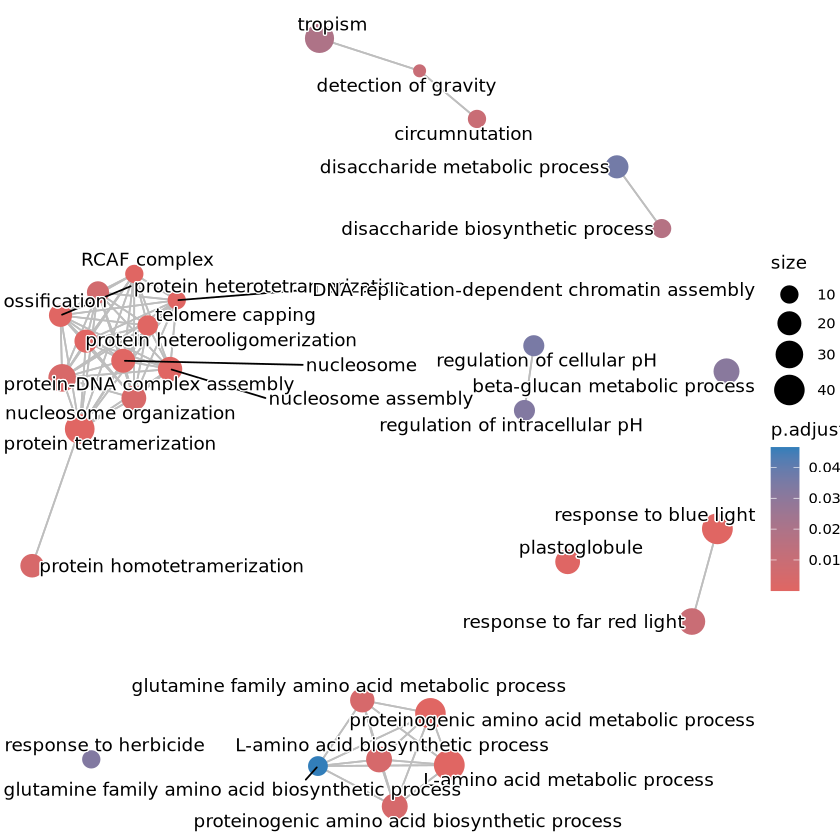

In [23]:
# 用于比较两个时期的基因富集通路占比，杨东可以尝试调试一下，搞不定就先放弃，参考链接：https://yulab-smu.top/biomedical-knowledge-mining-book/clusterprofiler-comparecluster.html

# library(clusterProfiler)
# data(gcSample)
# xx <- compareCluster(gcSample, fun="enrichKEGG",
#                      organism="hsa", pvalueCutoff=0.05)
# xx <- pairwise_termsim(xx)                     
# p1 <- emapplot(xx)
# p2 <- emapplot(xx, legend_n=2) 
# p3 <- emapplot(xx, pie="count")
# p4 <- emapplot(xx, pie="count", cex_category=1.5, layout="kk")
# cowplot::plot_grid(p1, p2, p3, p4, ncol=2, labels=LETTERS[1:4])